In [1]:
import pandas as pd
from numpy import mean
from scipy import stats #scipy란 과학기술 통계분석함수 모음이다.
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumGothicCoding'
plt.rcParams['axes.unicode_minus'] = False
import mglearn 
import missingno as msno

#### 검증 데이터셋(plant_test)에는 loc1,2,3 temp 데이터가 없고 그냥 plant와 loc에 따른 온도와 습도만 있다.

##### 과정 -> 기상상태 데이터에 따른 `공장내부 온도 습도 예측` -> 예측된 공장 내부 온도 습도에 따른 제철의 표면온도 예측 

##### -> 예측된 표면온도와 공장 내부 온도 습도에 따라 결로현상 예측 -> 결론적으로 기상상태에 따른 결로현상 예측모델 완성


In [3]:
# 기상청에서 받은 데이터 당진 AWS 기상데이터
for i in range(2016,2020):
    globals()['weather{}'.format(i)]=pd.read_csv('C:/Anaconda3/python/csvdata/hyundae/gogo/{}.csv'.format(i))

In [4]:
print(weather2016.shape)
print(weather2017.shape)
print(weather2018.shape)
print(weather2019.shape)

(524067, 4)
(523363, 4)
(524301, 4)
(518745, 4)


In [5]:
weather2016

,지점,일시,기온(°C),습도(%)
0,616,2016-01-01 0:01,-0.3,87.5
1,616,2016-01-01 0:02,-0.3,87.5
2,616,2016-01-01 0:03,-0.3,87.6
3,616,2016-01-01 0:04,-0.4,87.6
4,616,2016-01-01 0:05,-0.4,87.5
...,...,...,...,...
524062,616,2016-12-31 23:56,3.5,93.4
524063,616,2016-12-31 23:57,3.4,93.4
524064,616,2016-12-31 23:58,3.4,93.4
524065,616,2016-12-31 23:59,3.4,93.4


In [6]:
# 데이터중 풍향과 풍속은 제거한다.
weather2016

,지점,일시,기온(°C),습도(%)
0,616,2016-01-01 0:01,-0.3,87.5
1,616,2016-01-01 0:02,-0.3,87.5
2,616,2016-01-01 0:03,-0.3,87.6
3,616,2016-01-01 0:04,-0.4,87.6
4,616,2016-01-01 0:05,-0.4,87.5
...,...,...,...,...
524062,616,2016-12-31 23:56,3.5,93.4
524063,616,2016-12-31 23:57,3.4,93.4
524064,616,2016-12-31 23:58,3.4,93.4
524065,616,2016-12-31 23:59,3.4,93.4


In [6]:
#모든 데이터를 합친다. 이때 지점은 삭제해준다.
weather_df = pd.concat([weather2016,weather2017,weather2018,weather2019])

In [7]:
weather_df=weather_df[['일시','기온(°C)','습도(%)']]
#or del weather_df['지점']

In [8]:
weather_df

,일시,기온(°C),습도(%)
0,2016-01-01 0:01,-0.3,87.5
1,2016-01-01 0:02,-0.3,87.5
2,2016-01-01 0:03,-0.3,87.6
3,2016-01-01 0:04,-0.4,87.6
4,2016-01-01 0:05,-0.4,87.5
...,...,...,...
518740,2019-12-31 23:56,-6.3,77.8
518741,2019-12-31 23:57,-6.3,77.9
518742,2019-12-31 23:58,-6.3,77.7
518743,2019-12-31 23:59,-6.4,78.0


In [10]:
# weather_df 파일생성하기
weather_df.to_csv('C:/Anaconda3/python/csvdata/hyundae/gogo/weather_df.csv',encoding='utf-8')

In [10]:
#weather_df의 일시와 plant1_train의 일시가 같은것만 남깁니다.
#weather_df의 일시를 datetime으로 변경
weather_df['일시'] = pd.to_datetime(weather_df['일시'], format='%Y-%m-%d %H:%M:%S', errors='raise')
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2090476 entries, 0 to 518744
Data columns (total 3 columns):
 #   Column  Dtype         
---  ------  -----         
 0   일시      datetime64[ns]
 1   기온(°C)  float64       
 2   습도(%)   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 63.8 MB


In [ ]:
msno.matrix(weather_df)
weather_df.isna().sum() 
#기온 2656개 습도 20개의 결측치가 있다.

In [14]:
weather_df=weather_df.dropna(axis=0) #결측치가 포함된 행을 삭제한다

In [16]:
plant1_train=pd.read_csv('C:/Anaconda3/python/csvdata/hyundae/plant1_traincp.csv')
plant_test=pd.read_csv('C:/Anaconda3/python/csvdata/hyundae/plant_testcp.csv')

In [17]:
### 목적 : 입력되는 데이터(tem,hum,coil_tem,out_tem,out_hum)의 데이터로 결로현상을 예측하고 
# 발생가능성이 높을 경우 경고해주는 어플리케이션 개발

# 머신러닝 -> 분류, 회귀 모두 동작하겠지만 예측모델을 위해서 회귀 방식을 사용하겠음
# regression
# 참조 데이터셋 : ( 유방암 데이터셋) 



In [18]:
plant1_train=plant1_train.iloc[0:,1:]

In [19]:
plant_test=plant_test.iloc[0:,1:]

In [21]:
import missingno as msno

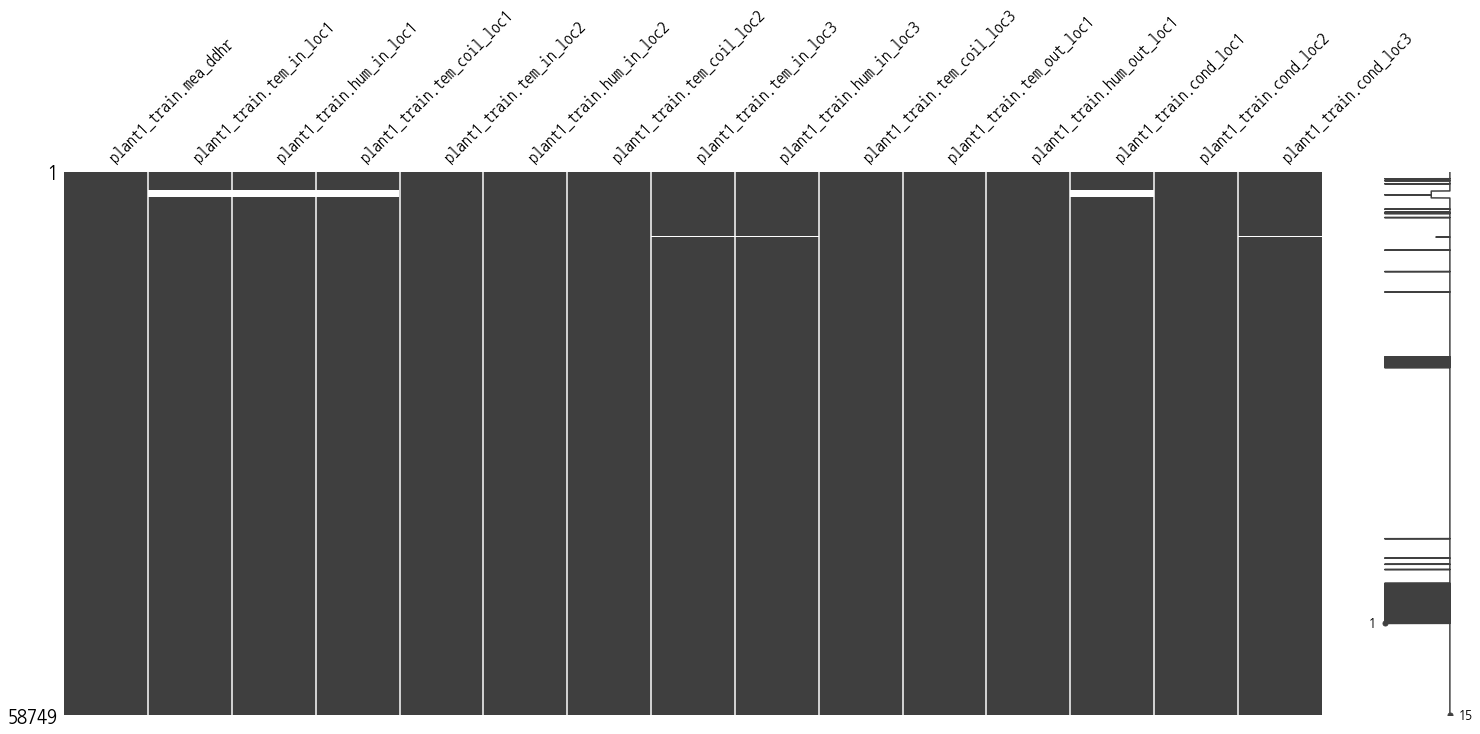

In [22]:
#결측치 분석
msno.matrix(plant1_train)



### plant1_trina.csv의 자료를 살펴본 결과
1) 2016~ 2016-12-26 23:00까지는 3시간 단위 데이터 측정  
2) 2016-12-22 9:00 ~ 2017-01-25 15:00 까지 tem_in_loc1,hum_in_loc1,tem_col_loc1의 데이터가 없다.  
3) 2018년 03-21-23:00부터 시간단위가 아닌 30분 단위로 계산된다.  
  - 2018-03-22 0:00   
  - 2018-03-22 0:30   

4) 2018-06-12 0:00~ 부터는 10분단위로 바뀐다. 이후 2019-03-31 23:50 까지 10분단위로 계산된다.  
  
5) 결론 : 기상데이터의 `일시`와 plant1데이터의 `mea_ddhr`의 공통된 부분만 뽑자(즉, plant1.csv의 1시간 단위 데이터만 획득할것)  



In [23]:
### 컬럼명 수정 ####

#다운 받을때 컬럼에 해당 파일명이 추가 된것 같다. 삭제해주자
plant1_train.columns=plant1_train.columns.str.replace('plant1_train.','')
plant1_train


,mea_ddhr,tem_in_loc1,hum_in_loc1,tem_coil_loc1,tem_in_loc2,hum_in_loc2,tem_coil_loc2,tem_in_loc3,hum_in_loc3,tem_coil_loc3,tem_out_loc1,hum_out_loc1,cond_loc1,cond_loc2,cond_loc3
0,2016-04-01 0:00,16.00,24.00,11.00,14.00,23.00,11.00,13.00,32.00,10.00,9.00,42.00,0.0,0.0,0.0
1,2016-04-01 3:00,14.00,28.00,10.00,12.00,32.00,9.00,11.00,42.00,7.00,7.00,59.00,0.0,0.0,0.0
2,2016-04-01 6:00,13.00,33.00,10.00,11.00,37.00,9.00,10.00,44.00,7.00,6.00,56.00,0.0,0.0,0.0
3,2016-04-01 9:00,13.00,33.00,10.00,11.00,35.00,9.00,10.00,41.00,8.00,18.00,30.00,0.0,0.0,0.0
4,2016-04-01 12:00,16.00,28.00,10.00,15.00,27.00,11.00,14.00,30.00,9.00,18.00,20.00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58744,2019-03-31 23:10,10.52,36.39,10.52,10.55,35.20,11.17,9.85,37.88,9.79,6.40,43.86,0.0,0.0,0.0
58745,2019-03-31 23:20,10.52,37.09,10.44,10.55,35.53,11.09,9.88,38.40,9.72,6.34,44.02,0.0,0.0,0.0
58746,2019-03-31 23:30,10.43,37.18,10.56,10.49,35.65,11.21,9.85,38.22,9.91,6.40,43.04,0.0,0.0,0.0
58747,2019-03-31 23:40,10.49,38.00,10.56,10.55,36.08,11.21,9.82,38.95,9.83,6.31,45.33,0.0,0.0,0.0


In [25]:
#시간부분이 object이므로 datetime으로 변환해준다.
plant1_train['mea_ddhr'] = pd.to_datetime(plant1_train['mea_ddhr'], format='%Y-%m-%d %H:%M:%S', errors='raise')


In [26]:
#회귀 분석모델을 만들어보자 일단 위치1의 temp,hum과 제철의 표면온도만 분석해보자
plant1=plant1_train[['mea_ddhr','tem_in_loc1','hum_in_loc1','tem_coil_loc1','cond_loc1']]
plant1

,mea_ddhr,tem_in_loc1,hum_in_loc1,tem_coil_loc1,cond_loc1
0,2016-04-01 00:00:00,16.00,24.00,11.00,0.0
1,2016-04-01 03:00:00,14.00,28.00,10.00,0.0
2,2016-04-01 06:00:00,13.00,33.00,10.00,0.0
3,2016-04-01 09:00:00,13.00,33.00,10.00,0.0
4,2016-04-01 12:00:00,16.00,28.00,10.00,0.0
...,...,...,...,...,...
58744,2019-03-31 23:10:00,10.52,36.39,10.52,0.0
58745,2019-03-31 23:20:00,10.52,37.09,10.44,0.0
58746,2019-03-31 23:30:00,10.43,37.18,10.56,0.0
58747,2019-03-31 23:40:00,10.49,38.00,10.56,0.0


In [27]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import seaborn as sns

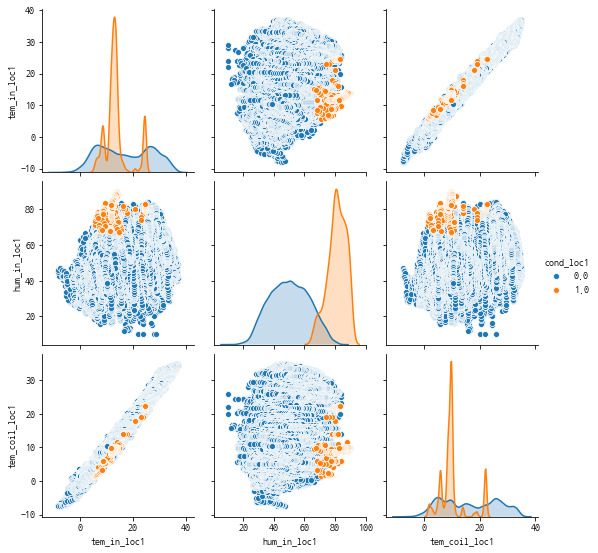

In [28]:
# 온도,습도,코일 표면온도와 결로현상의 상관관계 시각화(seaborn 사용)

sns.pairplot(plant1_train[['tem_in_loc1','hum_in_loc1','tem_coil_loc1','cond_loc1']], hue="cond_loc1")
plt.show()

In [29]:
test1=plant1_train[['tem_in_loc1','hum_in_loc1','tem_in_loc2','hum_in_loc2','tem_in_loc3','hum_in_loc3','tem_coil_loc1','cond_loc1']]

In [30]:
test1=test1.dropna(axis=0)

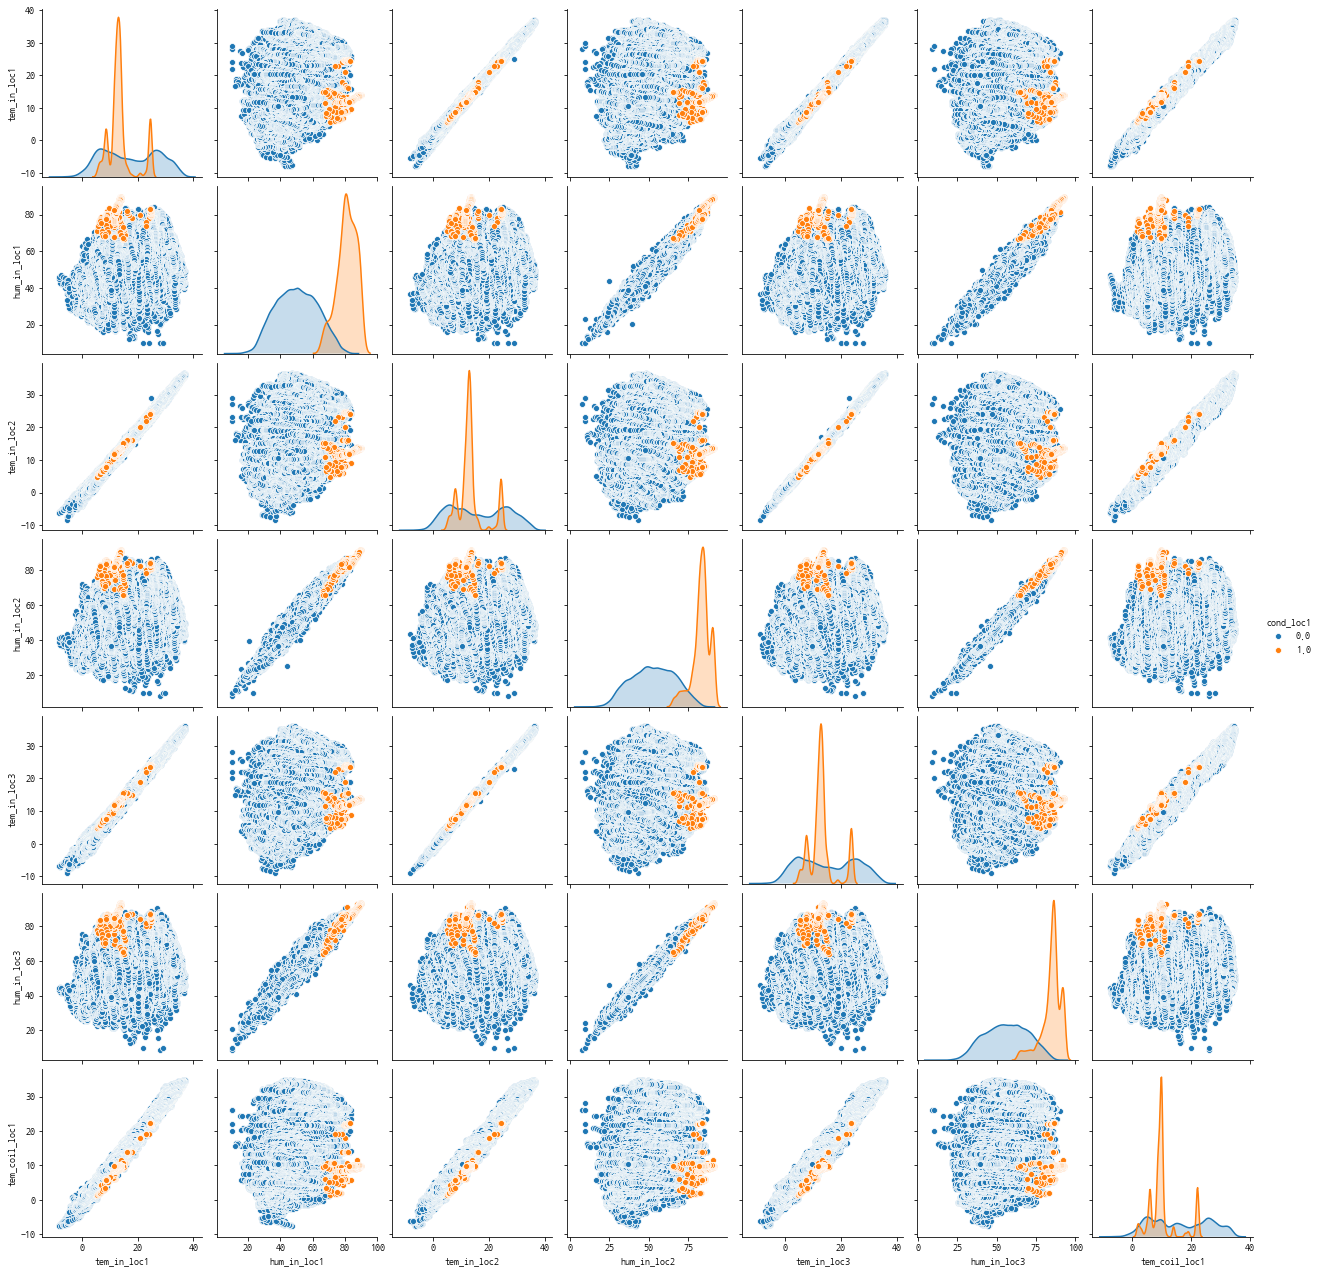

In [31]:
sns.pairplot(test1, hue="cond_loc1")
plt.show()

#결과간이분석
# tem_in_loc1 0~30도 사이일 경우 결로현상 발생
# hum_in_loc1 65% 이상일 경우 결로현상 발생
# hum_in_loc2 65% 이상일 경우 결로현상 발생
# tem_in_coil1 0~ 30도 사이일경우 결로 현상 발생

#즉, 상대습도 65% 이상 코일과 표면온도가 0~30도 사이일경우 결로현상이 발생했다고 볼수 있다.

In [32]:
#결로 발생시의 데이터 275건
test1[test1['cond_loc1']==1].shape

(275, 8)

In [33]:
#결과인 결로현상을 y1
#특성값들을 x1으로 array로 바꿔준다.
x1=test1[['tem_in_loc1','hum_in_loc1','tem_coil_loc1']].values
y1=test1['cond_loc1'].values
x1

array([[16.  , 24.  , 11.  ],
       [14.  , 28.  , 10.  ],
       [13.  , 33.  , 10.  ],
       ...,
       [10.43, 37.18, 10.56],
       [10.49, 38.  , 10.56],
       [10.49, 38.74, 10.52]])

In [34]:
y1

array([0., 0., 0., ..., 0., 0., 0.])

In [35]:
print('data =>',x1.shape)
print('target =>',y1.shape)

data => (57854, 3)
target => (57854,)


In [36]:
freeze = x1[y1==0]
nfreeze = x1[y1==1]

print('결로 미발생 =>',freeze.shape)
print('결로 발생 =>',nfreeze.shape)

결로 미발생 => (57579, 3)
결로 발생 => (275, 3)


In [37]:
_, bins=np.histogram(x1[:,0], bins=20)
np.histogram(x1[:,0], bins=20)

from sklearn import preprocessing


(array([  0.,   0.,   0.,   0.,   0.,   0.,  12.,  32.,  45., 129.,  18.,
          2.,   2.,   2.,  33.,   0.,   0.,   0.,   0.,   0.]),
 array([-7.98 , -5.727, -3.474, -1.221,  1.032,  3.285,  5.538,  7.791,
        10.044, 12.297, 14.55 , 16.803, 19.056, 21.309, 23.562, 25.815,
        28.068, 30.321, 32.574, 34.827, 37.08 ]),
 <a list of 20 Patch objects>)

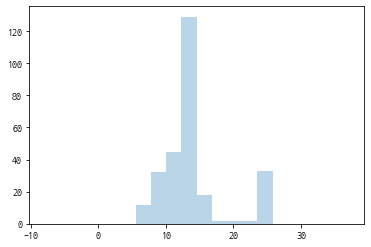

In [38]:
plt.hist(nfreeze[:,0],bins=bins, alpha=0.3)

(array([  16.,   65.,  187.,  924., 1908., 4089., 5344., 4628., 4515.,
        3531., 3422., 3268., 2817., 2787., 4250., 5094., 4329., 3124.,
        2475.,  806.]),
 array([-7.98 , -5.727, -3.474, -1.221,  1.032,  3.285,  5.538,  7.791,
        10.044, 12.297, 14.55 , 16.803, 19.056, 21.309, 23.562, 25.815,
        28.068, 30.321, 32.574, 34.827, 37.08 ]),
 <a list of 20 Patch objects>)

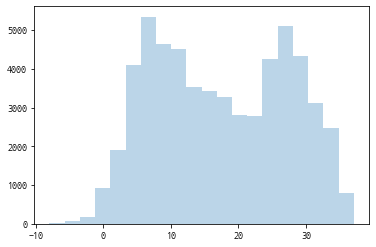

In [39]:
plt.hist(freeze[:,0], bins=bins ,alpha=0.3)


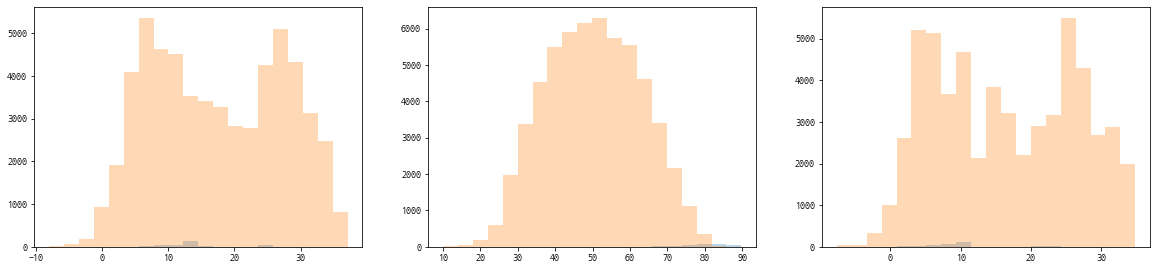

In [40]:
plt.figure(figsize=[20,15])

for col in range(3):
    plt.subplot(3,3,col+1)
    _, bins=np.histogram(x1[:,col], bins=20)
    plt.hist(nfreeze[:,col],bins=bins, alpha=0.3)
    plt.hist(freeze[:,col], bins=bins ,alpha=0.3)

    

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
import mglearn
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
plt.rcParams['font.family'] = 'NanumGothicCoding'
plt.rcParams['axes.unicode_minus'] = False

In [42]:
## 훈련을 위해 현재 가지고 있는 데이터 x1, y1을 살짝 분리해서 검증용과 훈련용으로 나눠보자(X_train,X_test,y_train,y_test)
# 물론 원본 데이터를 쪼개는 것이므로 train과 test의 합은 원본데이터의 전체합과 동일하다.


# 1. SVM으로 기계학습
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

In [43]:
x1

array([[16.  , 24.  , 11.  ],
       [14.  , 28.  , 10.  ],
       [13.  , 33.  , 10.  ],
       ...,
       [10.43, 37.18, 10.56],
       [10.49, 38.  , 10.56],
       [10.49, 38.74, 10.52]])

In [44]:
X_train, X_test, y_train, y_test =\
   train_test_split(x1, y1, random_state=0)

svc = SVC().fit(X_train, y_train)
print('훈련세트점수: {:.3f}'.format(svc.score(X_train, y_train)))
print('검증세트점수: {:.3f}'.format(svc.score(X_test, y_test)))

훈련세트점수: 0.998
검증세트점수: 0.998


In [45]:
#2. RandomForest로 기계학습
from sklearn.ensemble import RandomForestClassifier
forest=RandomForestClassifier(n_estimators=100,random_state=0).fit(X_train,y_train)

print('훈련세트 점수 : {:.3f}'.format(forest.score(X_train,y_train)))
print('검정세트 점수 : {:.3f}'.format(forest.score(X_test,y_test)))

훈련세트 점수 : 1.000
검정세트 점수 : 0.999


In [46]:
# 학습용 데이터셋에서 특성별로 최소값계산
min_on_training = X_train.min(axis=0)
# 특성별로 (최대값 - 최소값)의 범위를 계산
range_on_training = (X_train - min_on_training).max(axis=0)

# 학습용데이터셋에서 최소값을 빼고 범위로 나누면
# 각 특성에 대해서 최소값 0, 최대값은 1로 표준화가 됨
X_train_scaled = (X_train - min_on_training) / range_on_training
# print(X_train_scaled[:5])

print('특성별 최소값: {}'.format(X_train_scaled.min(axis=0)))
print('특성별 최대값: {}'.format(X_train_scaled.max(axis=0)))

특성별 최소값: [0. 0. 0.]
특성별 최대값: [1. 1. 1.]


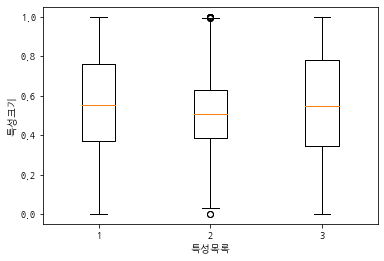

In [47]:
plt.boxplot(X_train_scaled, manage_ticks=True) #manage_ticks : x축의 값이 그래프에 모두 표시되게함
plt.xlabel("특성목록")
plt.ylabel("특성크기")
plt.show()

In [48]:
min_on_training = X_test.min(axis=0)
max_on_training = X_test.max(axis=0)
range_on_training = (X_test - min_on_training).max(axis=0)
X_test_scaled = (X_test - min_on_training) / range_on_training


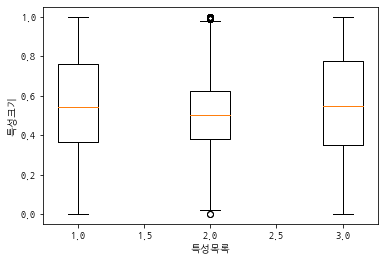

In [49]:
plt.boxplot(X_test_scaled, manage_ticks=False)
plt.xlabel("특성목록")
plt.ylabel("특성크기")
plt.show()

In [50]:
X_test_scaled = (X_test - min_on_training) / range_on_training

# 표준화된 데이터셋으로 다시 학습을 실시
svc = SVC().fit(X_train_scaled, y_train)
print('훈련세트점수: {:.3f}'.format(svc.score(X_train_scaled, y_train)))
print('검증세트점수: {:.3f}'.format(svc.score(X_test_scaled, y_test)))

# 결과분석
# 표준화전 훈련세트점수: 0.904 / 검증세트점수: 0.937
# 표준화후 훈련세트점수: 0.984 / 검증세트점수: 0.972

훈련세트점수: 0.998
검증세트점수: 0.998


In [51]:
# SVM의 매개변수(C, gamma)값을 증가시켜 더 복잡한 모델 만들기
svc = SVC(C=1000).fit(X_train_scaled, y_train)
print('훈련세트점수: {:.3f}'.format(svc.score(X_train_scaled, y_train)))
print('검증세트점수: {:.3f}'.format(svc.score(X_test_scaled, y_test)))

훈련세트점수: 1.000
검증세트점수: 0.999


In [52]:
#훈련 완료 
#표준화 후 SVM C=1000으로 설정하니 잘된다.
#검증용 데이터셋으로 확인해보자


In [53]:
plant_test.columns=plant_test.columns.str.replace('plant_test.','')
# plant1의 coil=1인 것만 볼거니까

plant1_loc1=plant_test[(plant_test['plant']==1)&(plant_test['loc']==1)]
plant1_loc2=plant_test[(plant_test['plant']==1)&(plant_test['loc']==2)]
plant1_loc3=plant_test[(plant_test['plant']==1)&(plant_test['loc']==3)]


#489개의 테스트 데이터다.
plant1_loc3

,mea_ddhr,plant,loc,tem_in,hum_in,tem_coil,tem_out_loc1,hum_out_loc1,x24h_tma,Unnamed: 10,x48h_tma
27,2019-04-03 12:30,1,3,12.63,47.31,9.37,11.43,50.15,2019-04-04 12:30,NaN,2019-04-05 12:30
43,2019-04-05 2:30,1,3,10.46,58.61,10.33,7.44,71.06,2019-04-06 2:30,NaN,2019-04-07 2:30
46,2019-04-05 8:00,1,3,11.95,72.31,10.63,10.34,78.08,2019-04-06 8:00,NaN,2019-04-07 8:00
48,2019-04-05 15:30,1,3,16.75,30.46,11.93,14.79,25.21,2019-04-06 15:30,NaN,2019-04-07 15:30
55,2019-04-06 6:30,1,3,9.18,42.70,11.01,4.60,54.33,2019-04-07 6:30,NaN,2019-04-08 6:30
...,...,...,...,...,...,...,...,...,...,...,...
3522,2020-03-27 19:00,1,3,13.63,41.42,14.07,9.73,52.32,2020-03-28 19:00,NaN,2020-03-29 19:00
3528,2020-03-28 7:30,1,3,10.61,23.75,12.16,7.34,30.92,2020-03-29 7:30,NaN,2020-03-30 7:30
3529,2020-03-28 13:30,1,3,12.23,24.05,12.88,10.34,27.26,2020-03-29 13:30,NaN,2020-03-30 13:30
3532,2020-03-28 23:30,1,3,10.76,34.83,12.08,7.47,42.06,2020-03-29 23:30,NaN,2020-03-30 23:30


In [ ]:
plant1_loc1=plant1_loc1.dropna(axis=1) #일단 필요없는 부분 제거
plant1_loc2=plant1_loc2.dropna(axis=1) #일단 필요없는 부분 제거
plant1_loc3=plant1_loc3.dropna(axis=1) #일단 필요없는 부분 제거
plant1_loc3

